<a href="https://colab.research.google.com/github/tmedeirosb/modelo_ifrn_integrado/blob/master/PPL_DROPOUT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install arviz

     |████████████████████████████████| 1.3MB 5.1MB/s 
     |████████████████████████████████| 4.1MB 38.4MB/s 
     |████████████████████████████████| 307kB 37.3MB/s 


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [2]:
#google drive
import os
from google.colab import drive

#impor database
drive.mount('/content/drive')
dados_tunning = pd.read_json('/content/drive/My Drive/Colab Notebooks/dados/dados_workflow_ivan.json')
dados = dados_tunning.copy()
dados.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(8908, 33)

In [3]:
from sklearn.model_selection import train_test_split

#config enviroment
#show all columns
pd.set_option('display.max_columns', None)

#clean the NaN
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape
    dados_dummies.columns = dados_dummies.columns.str.replace('[^a-zA-Z0-9]', '')
    #dados_dummies.columns = dados_dummies.columns.str.replace(' ', '_')

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)
  
#select attributes
atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#fill NAN
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#use original data
dados = dados[dados.artificial == 0]

print(dados.classe.value_counts())

dados.head(2)

#split data test and training. Stratify like imbalanced classes
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, stratify = y)

1    7369
0     349
Name: classe, dtype: int64
(7718, 31)
(7718, 31)
(7718, 151)


In [4]:
#balance data

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(Xtrain, ytrain)

#mantem em formato de dataframe
X_under = pd.DataFrame(X_under)
X_under.columns = Xtrain.columns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [5]:
print(X_under.shape)
X_under.head(3)

(524, 151)


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90Hdependencia,LnguaPortuguesaeLiteraturaI90Hfreq,MatemticaI120H,MatemticaI120Hdependencia,MatemticaI120Hfreq,acompanhamento,alunoexclusivoredepublica,artificial,idade,possuinecessidadeespecial,qntpc,qntsalarios,qtdpessoasdomicilio,tempoentreconclusaoingresso,conceitoI,conceitoO,conceitoR,conceitoS,conceitofreqI,conceitofreqR,conceitofreqS,descricaoarearesidencialComunidadeQuilombola,descricaoarearesidencialNoinformado,descricaoarearesidencialRural,descricaoarearesidencialUrbana,descricaocompanhiadomiciliarMe,descricaocompanhiadomiciliarNoinformado,descricaocompanhiadomiciliarOutros,descricaocompanhiadomiciliarPai,descricaocompanhiadomiciliarPais,descricaocompanhiadomiciliarParentesouamigos,descricaocompanhiadomiciliarSozinhoa,descricaoestadocivilDivorciadoa,descricaoestadocivilNodeclarado,descricaoestadocivilSolteiroa,descricaoestadocivilUnioEstvel,descricaohistoricoTcnicodeNivelMdioemAgropecurianaFormaIntegrada,descricaohistoricoTcnicodeNivelMdioemBiocombustveis,descricaohistoricoTcnicodeNivelMdioemEquipamentosBiomdicos,descricaohistoricoTcnicodeNivelMdioemInformtica,descricaohistoricoTcnicodeNvelMdioemAdministrao,descricaohistoricoTcnicodeNvelMdioemAgroecologia,descricaohistoricoTcnicodeNvelMdioemAlimentos,descricaohistoricoTcnicodeNvelMdioemApicultura,descricaohistoricoTcnicodeNvelMdioemComrcio,descricaohistoricoTcnicodeNvelMdioemControleAmbiental,descricaohistoricoTcnicodeNvelMdioemEdificaes,descricaohistoricoTcnicodeNvelMdioemEletromecnica,descricaohistoricoTcnicodeNvelMdioemEletrotcnica,descricaohistoricoTcnicodeNvelMdioemEletrnica,descricaohistoricoTcnicodeNvelMdioemEventos,descricaohistoricoTcnicodeNvelMdioemGeologia,descricaohistoricoTcnicodeNvelMdioemInformtica,descricaohistoricoTcnicodeNvelMdioemInformticaparaInternet,descricaohistoricoTcnicodeNvelMdioemLazer,descricaohistoricoTcnicodeNvelMdioemLogstica,descricaohistoricoTcnicodeNvelMdioemManutenoeSuporteemInformtica,descricaohistoricoTcnicodeNvelMdioemMecatrnica,descricaohistoricoTcnicodeNvelMdioemMecnica,descricaohistoricoTcnicodeNvelMdioemMeioAmbiente,descricaohistoricoTcnicodeNvelMdioemMinerao,descricaohistoricoTcnicodeNvelMdioemMultimdia,descricaohistoricoTcnicodeNvelMdioemQumica,descricaohistoricoTcnicodeNvelMdioemQumicanaFormaIntegrado,descricaohistoricoTcnicodeNvelMdioemRecursosPesqueiros,descricaohistoricoTcnicodeNvelMdioemRefrigeraoeClimatizao,descricaohistoricoTcnicodeNvelMdioemTxtil,descricaohistoricoTcnicodeNvelMdioemVesturio,descricaohistoricoTcnicoemProgramaodeJogosDigitais,descricaoimovelCedidoouEmprestado,descricaoimovelFinanciado,descricaoimovelNoinformado,descricaoimovelOutro,descricaoimovelPensionatoouAlojamento,descricaoimovelPrprio,descricaomaeescolaridadeEnsinofundamentalcompleto,descricaomaeescolaridadeEnsinofundamentalincompleto,descricaomaeescolaridadeEnsinomdiocompleto,descricaomaeescolaridadeEnsinomdioincompleto,descricaomaeescolaridadeEnsinosuperiorcompleto,descricaomaeescolaridadeEnsinosuperiorincompleto,descricaomaeescolaridadeNoconhece,descricaomaeescolaridadeNoestudou,descricaomaeescolaridadePsgraduaocompleto,descricaomaeescolaridadePsgraduaoincompleto,descricaopaiescolaridadeEnsinofundamentalcompleto,descricaopaiescolaridadeEnsinofundamentalincompleto,descricaopaiescolaridadeEnsinomdiocompleto,descricaopaiescolaridadeEnsinomdioincompleto,descricaopaiescolaridadeEnsinosuperiorcompleto,descricaopaiescolaridadeEnsinosuperiorincompleto,descricaopaiescolaridadeNoconhece,descricaopaiescolaridadeNoestudou,descricaopaiescolaridadePsgraduaocompleto,descricaopaiescolaridadePsgraduaoincompleto,descricaoracaBranca,descricaoracaIndgena,descricaoracaNodeclarado,descricaoracaParda,descricaoracaPreta,descricaoresponsavelescolaridadeEnsinofundamentalcompleto,descricaoresponsavelescolaridadeEnsinofundamentalincompleto,descricaoresponsavelescolaridadeEnsinomdiocompleto,descricaoresponsavelescolaridadeEnsinomdioincompleto,descricaoresponsavelescolaridadeEnsinosuperiorcompleto,descricaoresponsa

In [8]:
from sklearn.feature_selection import RFECV
from imblearn.metrics import geometric_mean_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer

#select best attributes
selector = RFECV(LogisticRegression(solver="lbfgs"), 
                 cv=10, 
                 n_jobs=-1, 
                 scoring=make_scorer(geometric_mean_score))

selector.fit(X_under, y_under)

RFECV(cv=10,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1,
      scoring=make_scorer(geometric_mean_score), step=1, verbose=0)

In [9]:
best_columns = list(X_under.columns[selector.support_])
print("Best Columns \n{}\n".format(best_columns))    

Best Columns 
['conceitoI', 'conceitoO', 'conceitoR', 'conceitofreqR', 'descricaohistoricoTcnicodeNvelMdioemEdificaes', 'descricaohistoricoTcnicodeNvelMdioemMecatrnica', 'descricaopaiescolaridadeNoconhece', 'descricaoresponsavelfinanceiroIrmo']



(524, 9)


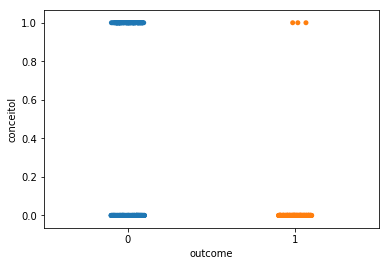

In [16]:
dados_label = X_under[best_columns]
dados_label["outcome"] = y_under

print(dados_label.shape)

sns.stripplot(x="outcome", y="conceitoI", data=dados_label, jitter=True)
plt.show();

In [17]:
#dados_label.astype(float).corr(method="kendall")
dados_label.astype(float).corr(method="kendall")['outcome'].sort_values(ascending=False)

outcome                                           1.000000
conceitoO                                         0.234581
descricaohistoricoTcnicodeNvelMdioemMecatrnica    0.102062
descricaopaiescolaridadeNoconhece                 0.019031
descricaoresponsavelfinanceiroIrmo               -0.043853
descricaohistoricoTcnicodeNvelMdioemEdificaes    -0.100618
conceitofreqR                                    -0.283241
conceitoI                                        -0.418629
conceitoR                                        -0.486911
Name: outcome, dtype: float64

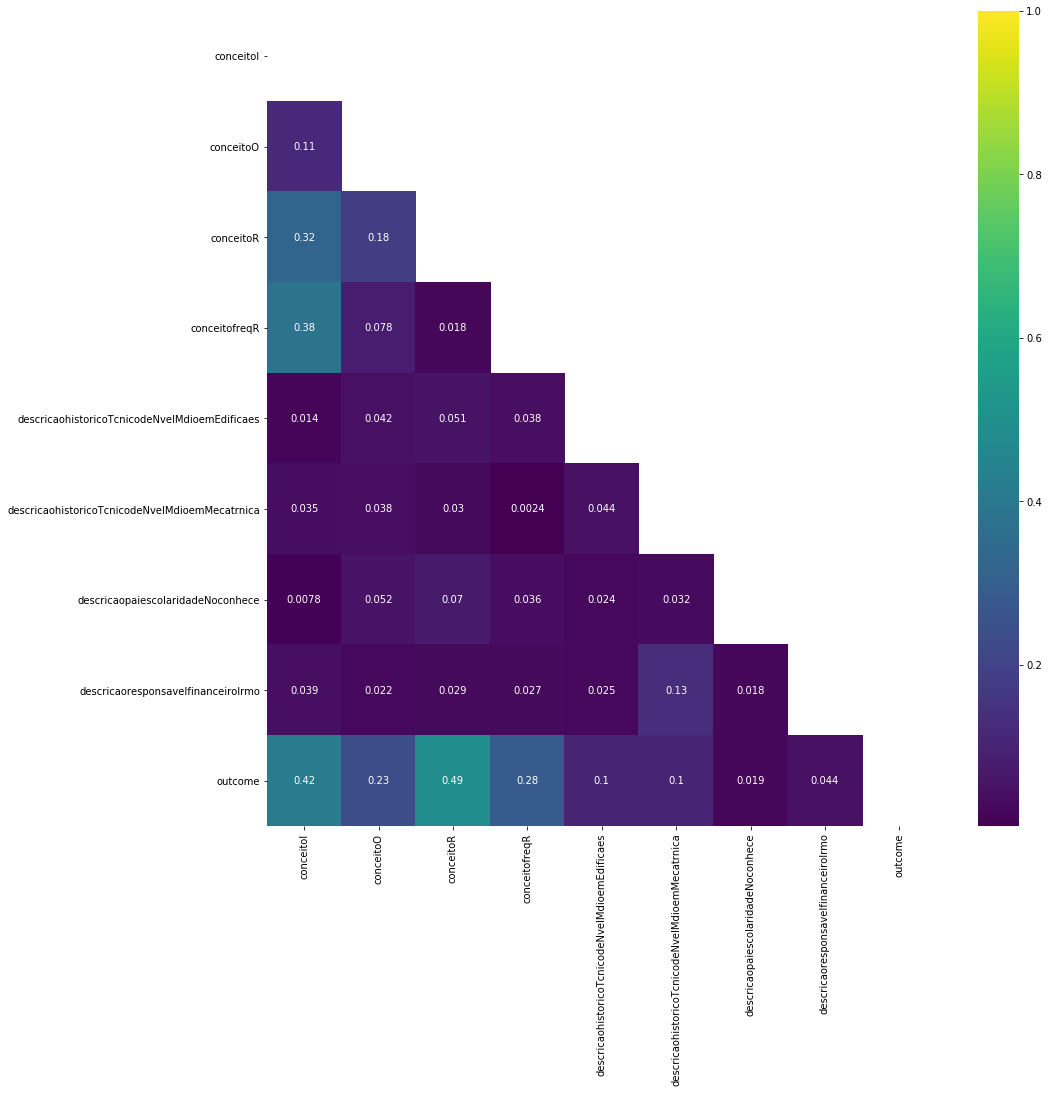

In [18]:
plt.figure(figsize=(15, 15))
corr = dados_label.astype(float).corr(method="kendall")
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

In [0]:
#import seaborn
#g = seaborn.pairplot(dados_label.astype(float))

In [19]:
#gerar auto formula
#nao pode usar o nome class
formula = 'outcome ~ ' + ''.join([feat + ' + ' for feat in dados_label.drop('outcome', axis=1)])[:-3]
print(formula)

outcome ~ conceitoI + conceitoO + conceitoR + conceitofreqR + descricaohistoricoTcnicodeNvelMdioemEdificaes + descricaohistoricoTcnicodeNvelMdioemMecatrnica + descricaopaiescolaridadeNoconhece + descricaoresponsavelfinanceiroIrmo


In [20]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula, 
                            dados_label, 
                            family = pm.glm.families.Binomial())
    #trace = pm.sample(10000, tune = 1000, cores = 10, init = 'adapt_diag')
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [descricaoresponsavelfinanceiroIrmo[T.1], descricaopaiescolaridadeNoconhece[T.1], descricaohistoricoTcnicodeNvelMdioemMecatrnica[T.1], descricaohistoricoTcnicodeNvelMdioemEdificaes[T.1], conceitofreqR[T.1], conceitoR[T.1], conceitoO[T.1], conceitoI[T.1], Intercept]
100%|██████████| 2000/2000 [00:05<00:00, 386.62it/s]


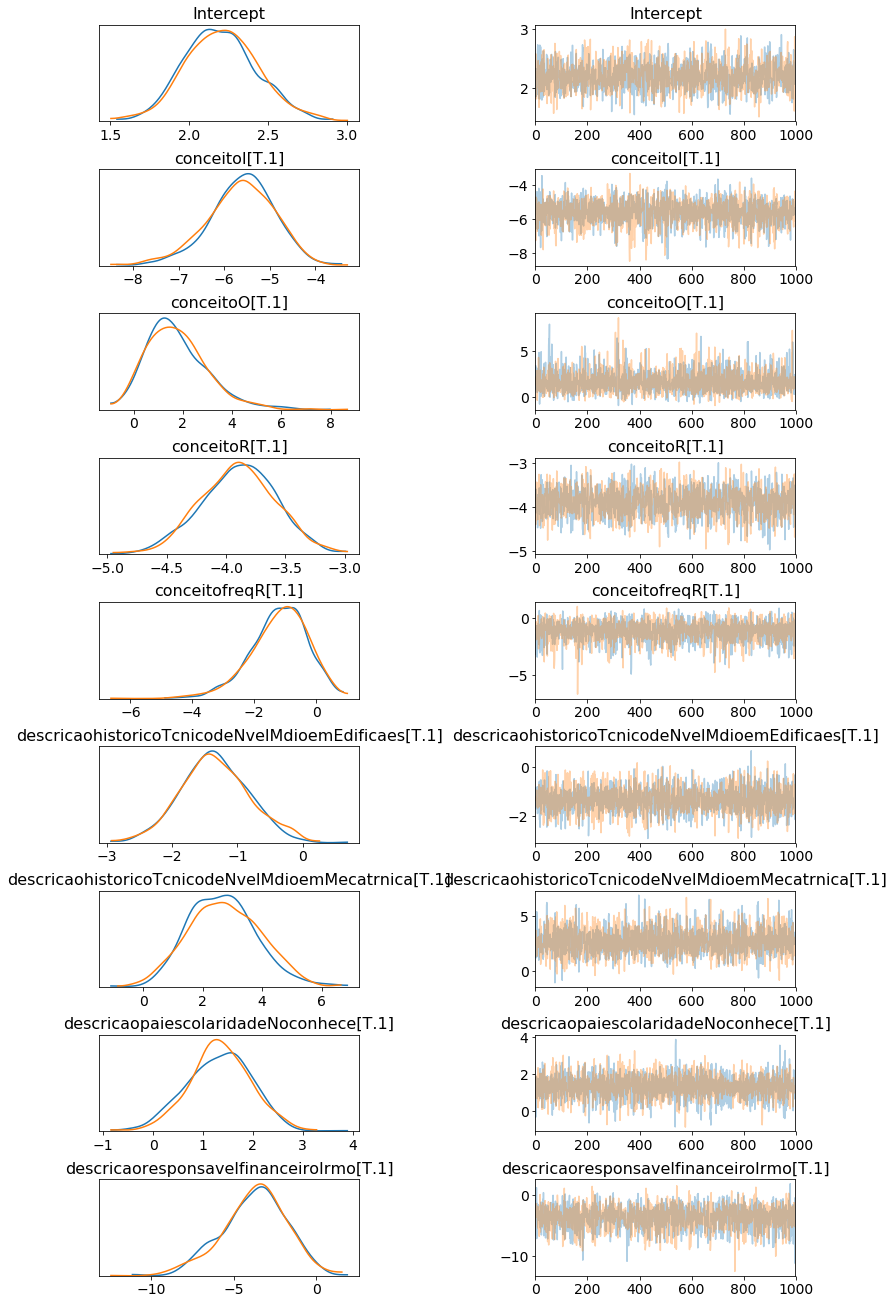

In [21]:
az.plot_trace(trace);

In [22]:
stat_df = pm.summary(trace)
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat,odds_ratio,percentage_effect
Intercept,2.203399,0.229727,0.005345,1.731209,2.635163,1654.366098,1.000446,9.055743,805.574327
conceitoI[T.1],-5.622306,0.726808,0.015958,-7.052735,-4.230888,1919.649424,1.001140,0.003616,-99.638371
conceitoO[T.1],1.784642,1.252847,0.027709,-0.354956,4.294596,1989.814514,0.999501,5.957449,495.744891
conceitoR[T.1],-3.894575,0.314442,0.007284,-4.478621,-3.256214,1861.564326,0.999617,0.020352,-97.964797
conceitofreqR[T.1],-1.193775,0.910083,0.019906,-3.024191,0.458422,2443.498116,0.999615,0.303075,-69.692512
descricaohistoricoTcnicodeNvelMdioemEdificaes[T.1],-1.342401,0.521978,0.009481,-2.313112,-0.221274,2974.893041,0.999689,0.261218,-73.878235
descricaohistoricoTcnicodeNvelMdioemMecatrnica[T.1],2.708370,1.182990,0.022419,0.579763,5.061681,2418.043466,1.000543,15.004797,1400.479670
descricaopaiescolaridadeNoconhece[T.1],1.338114,0.636737,0.010267,0.117057,2.579215,3109.990696,1.000016,3.811849,281.184924
descricaoresponsavelfinanceiroIrmo[T.1],-3.751444,1.929441,0.038227,-7.986915,-0.507640,2483.479406,0.999522,0.023484,-97.651618


(<Figure size 432x993.6 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0756205f28>],
       dtype=object))

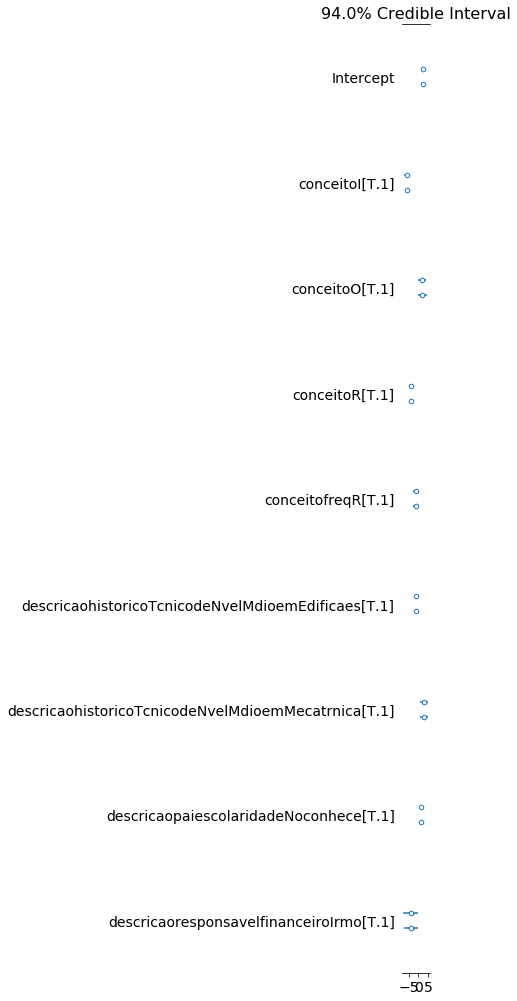

In [23]:
az.plot_forest(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0756044d30>,
      dtype=object)

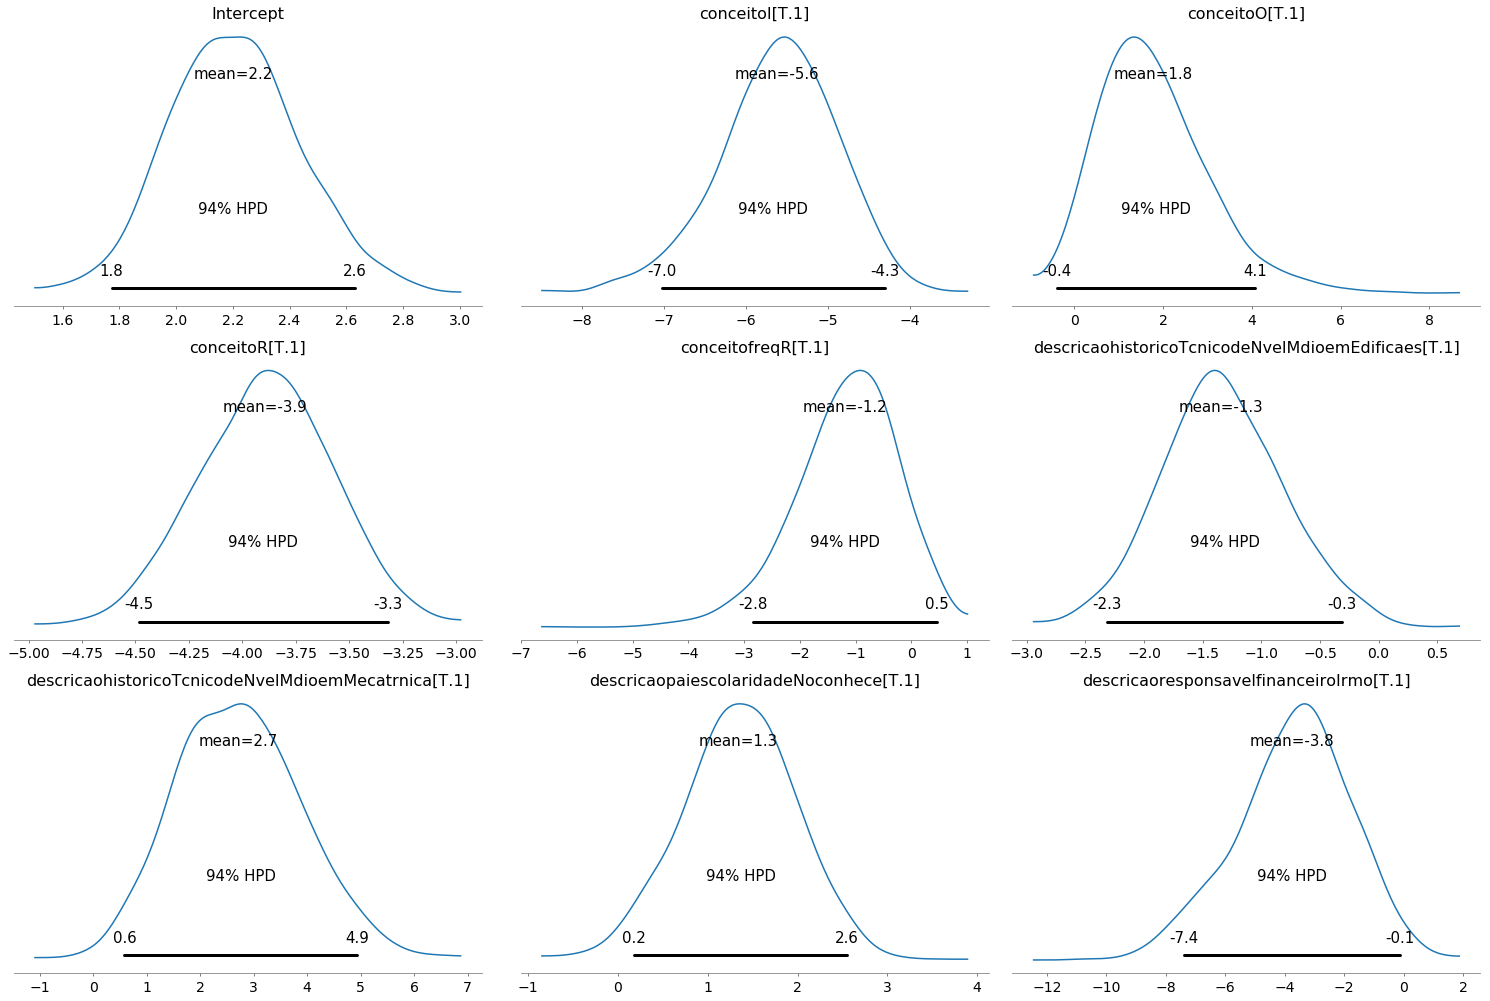

In [24]:
pm.plot_posterior(trace)

In [30]:
#df_trace = pm.trace_to_dataframe(trace[10000//2:])
df_trace = pm.trace_to_dataframe(trace)
df_trace.columns[1:]

Index(['conceitoI[T.1]', 'conceitoO[T.1]', 'conceitoR[T.1]',
       'conceitofreqR[T.1]',
       'descricaohistoricoTcnicodeNvelMdioemEdificaes[T.1]',
       'descricaohistoricoTcnicodeNvelMdioemMecatrnica[T.1]',
       'descricaopaiescolaridadeNoconhece[T.1]',
       'descricaoresponsavelfinanceiroIrmo[T.1]'],
      dtype='object')

In [31]:
#exclui a primeira coluna que eh intercept
mu_trace = df_trace[df_trace.columns[1:]].mean(axis=0)

def predict(Xtest, mu_trace, intercept):
  #print(mu_trace)
  #print(Xtest.columns)
  #print(intercept)
  tmp = Xtest * mu_trace
  v = intercept + tmp.sum(axis=1)
  return np.exp(v)/(1+np.exp(v))
  
df_predict = predict(Xtest[best_columns], mu_trace.values, df_trace['Intercept'].mean())
df_predict = round(df_predict)

df_predict

8117    1.0
3055    1.0
1929    1.0
8106    1.0
4132    1.0
5511    1.0
5658    1.0
3864    1.0
1138    1.0
2567    1.0
8336    1.0
7693    1.0
9216    1.0
1849    1.0
1733    1.0
3719    1.0
1598    1.0
1812    1.0
4010    1.0
8923    1.0
2521    1.0
6006    1.0
7137    1.0
4544    1.0
8181    0.0
3251    1.0
4017    1.0
6723    1.0
3008    1.0
223     1.0
       ... 
2339    0.0
8855    0.0
5922    1.0
9099    1.0
6821    1.0
4729    1.0
3393    0.0
6727    1.0
2237    1.0
8233    1.0
7757    1.0
6281    0.0
6187    1.0
6637    1.0
5948    1.0
6972    1.0
4241    1.0
8236    0.0
6038    1.0
6322    1.0
7581    1.0
9164    1.0
6450    1.0
2451    1.0
709     0.0
5136    1.0
6592    1.0
5085    1.0
8776    1.0
4012    1.0
Length: 1930, dtype: float64

In [40]:
cm = confusion_matrix(ytest, df_predict)
print(cm)

print('Accuracy of the simplest model:', accuracy_score(ytest, df_predict))
print('f1 score of the simplest model:', f1_score(ytest, df_predict))
print('G-mean score of the simplest model:', geometric_mean_score(ytest, df_predict))

[[  78    9]
 [ 255 1588]]
Accuracy of the simplest model: 0.8632124352331606
f1 score of the simplest model: 0.9232558139534883
G-mean score of the simplest model: 0.8789218404948641


Confusion matrix
[[  78    9]
 [ 255 1588]]


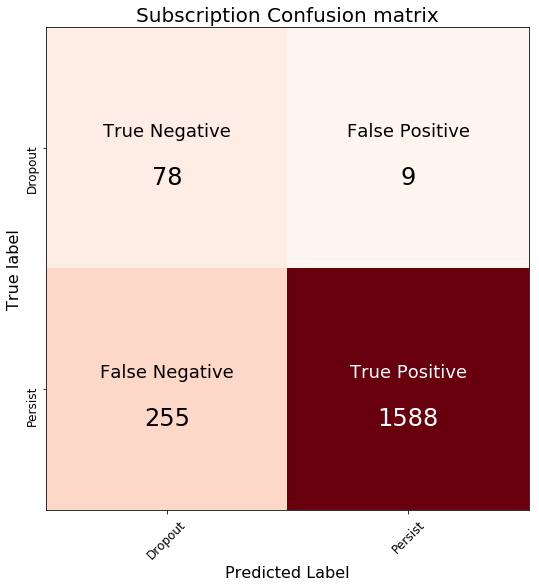

In [33]:
def plot_confusion_matrix(cm, classes = ['Dropout', 'Persist'],
                          title='Subscription Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)
    
#cm = confusion_matrix(data['outcome'], preds)
plot_confusion_matrix(cm)

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(ytest, df_predict)
g = geometric_mean_score(ytest, df_predict)

class_report = classification_report(ytest, df_predict, output_dict=True)
#class_report

res = pd.DataFrame({'name' : ['PPL'], 
                                    'precision' : [class_report["1"]["precision"]], 
                                    'recall' : [class_report["1"]["recall"]], 
                                    'f1' : [class_report["1"]["f1-score"]], 
                                    'auc' : [auc], 
                                    'g-mean' : [g]
                                    })
res

,name,precision,recall,f1,auc,g-mean
0,PPL,0.994364,0.861639,0.923256,0.879095,0.878922


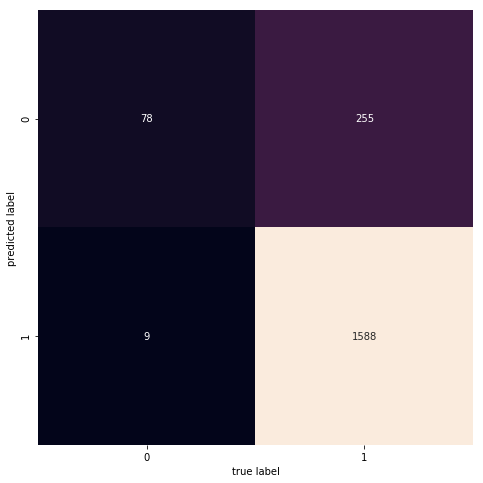

In [42]:
mat = confusion_matrix(ytest, df_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
